In [1]:
import numpy as np 
import pandas as pd 
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.signal import deconvolve
from analysis import *

In [13]:
def fourierExtrapolation(x, n_predict, n_harm=10):
    n = x.size

    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)

    x_notrend = x - p[0] * t - p[1]            # signal detrended 
    x_freqdom = np.fft.fft(x_notrend)   # signal in frequencies domain
    f = np.fft.fftfreq(n)               # frequencies

    indexes = list(range(n))
    indexes.sort(key= lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sign = np.zeros(t.size)

    for i in indexes[:1 + n_harm * 2]:
        amplitude = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sign += amplitude * np.cos(2 * np.pi * f[i] * t + phase)
    
    return restored_sign + p[0] * t + p[1]

In [3]:
data = pd.read_csv("Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)

Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0

Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric['Seconds'] = (Electric.Date - Electric.Date[0]).dt.total_seconds()
Electric = Electric[['Date', 'Seconds', 'Load']]
Electric['Day'] = Electric['Date'].dt.day_name()
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour
Electric.columns

Index(['Date', 'Seconds', 'Load', 'Day', 'Minutes', 'Hour'], dtype='object')

In [16]:
signal_reconstr = fourierExtrapolation(Electric.Load.values, int(96*7), n_harm=40)

[ 0.00000000e+00  3.16808597e-06 -3.16808597e-06  6.33617194e-06
 -6.33617194e-06  9.50425791e-06 -9.50425791e-06  1.26723439e-05
 -1.26723439e-05  1.58404298e-05 -1.58404298e-05  1.90085158e-05
 -1.90085158e-05  2.21766018e-05 -2.21766018e-05  2.53446878e-05
 -2.53446878e-05  2.85127737e-05 -2.85127737e-05  3.16808597e-05
 -3.16808597e-05  3.48489457e-05 -3.48489457e-05  3.80170316e-05
 -3.80170316e-05  4.11851176e-05 -4.11851176e-05  4.43532036e-05
 -4.43532036e-05  4.75212895e-05 -4.75212895e-05  5.06893755e-05
 -5.06893755e-05  5.38574615e-05 -5.38574615e-05  5.70255474e-05
 -5.70255474e-05  6.01936334e-05 -6.01936334e-05  6.33617194e-05
 -6.33617194e-05  6.65298054e-05 -6.65298054e-05  6.96978913e-05
 -6.96978913e-05  7.28659773e-05 -7.28659773e-05  7.60340633e-05
 -7.60340633e-05  7.92021492e-05 -7.92021492e-05  8.23702352e-05
 -8.23702352e-05  8.55383212e-05 -8.55383212e-05  8.87064071e-05
 -8.87064071e-05  9.18744931e-05 -9.18744931e-05  9.50425791e-05
 -9.50425791e-05  9.82106

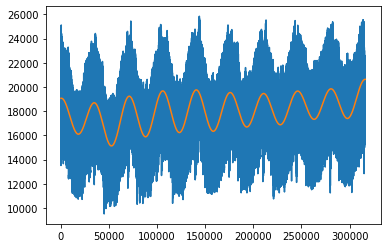

In [12]:
plt.plot(Electric.Load.values)
plt.plot(signal_reconstr)

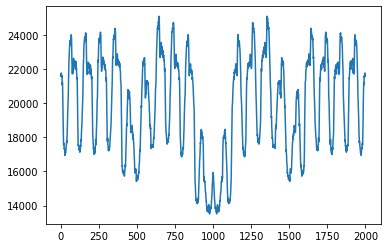

In [48]:
plt.plot(np.concatenate([Electric.Load.values[:1000][::-1], Electric.Load.values[:1000]]))
#plt.xlim(900,1000)

In [ ]:
# prima di fare le analisi simili a quelle di gioacchino bisogna estendere 
# il segnale in modo tale da eliminare gli effetti sui bordi dati dalla
# convoluzione.

In [69]:
psf = Electric.groupby(['Hour', 'Minutes']).mean().reset_index()['Load'].to_numpy()
psf /= psf.sum()

In [79]:
f = {'Load': ['mean', q1, q2]}

psfs = Electric.groupby(['Hour', 'Minutes']).agg(f).reset_index()['Load'].to_numpy()

In [81]:
psf = psfs[:, 0]
psf_q1 = psfs[:, 1]
psf_q2 = psfs[:, 2]

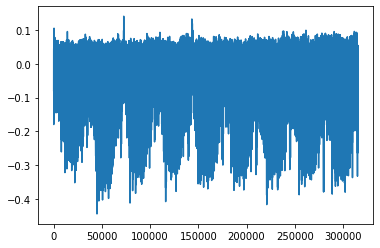

In [88]:
load = Electric.Load.values

def dec(signal, psf, window=96):
    deconv=np.zeros(len(signal))
    for i in range(len(signal)//window):
        deconv[i*window:(i+1)*window +1] = deconvolve(signal[(i*window) : (i+2)*window], psf)[0]
        deconv[(i+1)*window:(i+2)*window+1] = deconvolve(signal[(i+1)*window:(i+3)*window], psf)[0]
    return deconv

deconv_psf = dec(load, psf)
deconv_psfq1 = dec(load, psf_q1)
deconv_psfq2 = dec(load, psf_q2)

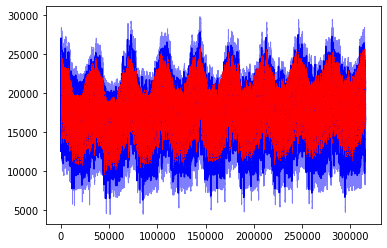

In [96]:
load_psf = np.convolve(deconv_psf, psf, 'valid')[:-96]
load_q1 = np.convolve(deconv_psfq1, psf_q1, 'valid')[:-96]
load_q2 = np.convolve(deconv_psfq2, psf_q2, 'valid')[:-96]
t = range(len(load_psf))

plt.plot(load_psf, 'b')
plt.fill_between(x=t, y1=load_q1, y2=load_q2, color='b', alpha=0.5)
plt.plot(load, ',r', alpha=0.5)